# Bài thực hành 4: So sánh sự tương đồng của các hình ảnh sử dụng Wavelet, Python

**Môn học**: Computer Vision and Image Processing (CVIP)  
**Trường**: Đại học Công nghệ TP.HCM (UTH)

---

## Mục lục

- [I> Mục tiêu bài tập](#i-mục-tiêu-bài-tập)
- [II> Bài toán cụ thể](#ii-bài-toán-cụ-thể)
  - [II.1 - Chuẩn bị dữ liệu](#ii1---chuẩn-bị-dữ-liệu)
  - [II.2 - Trích xuất wavelet đặc biệt](#ii2---trích-xuất-wavelet-đặc-biệt)
  - [II.3 - Tạo mã băm wavelet](#ii3---tạo-mã-băm-wavelet)
  - [II.4 - So sánh hàm băm (Hamming Distance)](#ii4---so-sánh-hàm-băm-hamming-distance)
  - [II.5 - Đánh giá](#ii5---đánh-giá)
- [III> Bài tập nâng cao](#iii-bài-tập-nâng-cao)
  - [III.1 - So sánh các phương pháp băm wavelet](#iii1---so-sánh-các-phương-pháp-băm-wavelet)
  - [III.2 - Ứng dụng tìm kiếm hình ảnh (Image Retrieval)](#iii2---ứng-dụng-tìm-kiếm-hình-ảnh-image-retrieval)

---

## Setup & Import

In [1]:
# ========================================
# SETUP - Chỉ chạy 1 lần
# ========================================

import sys
from pathlib import Path

# Đảm bảo có thể import từ src/
PROJECT_ROOT = Path().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Tạo thư mục output nếu chưa có
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
FIGURES_DIR = OUTPUTS_DIR / "figures"
TABLES_DIR = OUTPUTS_DIR / "tables"
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

for d in [FIGURES_DIR, TABLES_DIR, PROCESSED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"[OK] Project root: {PROJECT_ROOT}")
print(f"[OK] Outputs: {OUTPUTS_DIR}")

[OK] Project root: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)
[OK] Outputs: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs


In [2]:
# ========================================
# IMPORTS
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
from PIL import Image
import cv2
import warnings

# Sklearn metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Skimage sample images
from skimage import data

# Import từ src/
from src.preprocessing import (
    load_and_preprocess,
    load_image_array,
    generate_synthetic_pairs,
    create_image_pairs_from_folder,
    save_pairs_to_csv
)
from src.wavelet_hash import (
    dwt2,
    get_feature_vector,
    quantize_to_bits,
    wavelet_hash,
    wavelet_hash_simple,
    visualize_wavelet_decomposition,
    WaveletHashConfig,
    DEFAULT_CONFIG
)
from src.metrics import (
    hamming_distance,
    calculate_metrics,
    find_optimal_threshold,
    compute_roc_auc,
    evaluate_method_on_pairs,
    plot_roc_curve,
    plot_confusion_matrix
)
from src.retrieval import (
    build_hash_gallery_from_arrays,
    retrieve_similar_images,
    display_retrieval_results
)

# Config
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Random seed cho reproducibility
SEED = 42
np.random.seed(SEED)

print("[OK] Đã import tất cả thư viện")
print(f"  - PyWavelets version: {pywt.__version__}")
print(f"  - NumPy version: {np.__version__}")

[OK] Đã import tất cả thư viện
  - PyWavelets version: 1.8.0
  - NumPy version: 2.1.3


---

# I> Mục tiêu bài tập

Bài thực hành này nhằm mục đích:

1. **Biết cách sử dụng wavelet biến đổi** để trích xuất thông tin cụ thể và so sánh sự tương thích giữa các hình ảnh.

2. **Làm quen với PyWavelets** thư viện và các công cụ xử lý ảnh trong Python.

3. **Đánh giá kết quả** của hàm băm wavelet phương pháp trong việc xác định các hình ảnh tương thích.

---

# II> Bài toán cụ thể

## II.1 - Chuẩn bị dữ liệu

Chuẩn bị một tập hợp các hình ảnh, bao gồm:
- **Các hình ảnh cặp đôi tương tự nhau**: Ví dụ cùng một đối tượng với các góc độ khác nhau, các mức độ nhiễu khác nhau
- **Các hình ảnh cặp không tương tự**: Các đối tượng hoàn toàn khác nhau

### Lựa chọn nguồn dữ liệu

Notebook hỗ trợ 2 nguồn:
1. **Synthetic**: Tự động tạo từ ảnh mẫu `skimage.data` (không cần chuẩn bị gì)
2. **Custom**: Đọc từ thư mục `data/raw/similar/` và `data/raw/dissimilar/`

In [3]:
# ========================================
# CHỌN NGUỒN DỮ LIỆU
# ========================================

USE_SYNTHETIC = True  # True = dùng ảnh mẫu, False = dùng ảnh từ thư mục

if USE_SYNTHETIC:
    # Tạo dataset từ ảnh mẫu scikit-image
    print("[INFO] Đang tạo dataset từ ảnh mẫu scikit-image...")
    
    image_pairs, labels = generate_synthetic_pairs(
        num_similar=10,
        num_dissimilar=10,
        seed=SEED
    )
    
else:
    # Đọc từ thư mục
    RAW_DATA_DIR = DATA_DIR / "raw"
    
    if (RAW_DATA_DIR / "similar").exists():
        print(f"[INFO] Đang đọc dữ liệu từ: {RAW_DATA_DIR}")
        
        pairs_list = create_image_pairs_from_folder(
            RAW_DATA_DIR,
            output_csv=PROCESSED_DIR / "pairs.csv"
        )
        
        # Chuyển thành format (img1, img2, description) và labels
        image_pairs = []
        labels = []
        for p1, p2, y in pairs_list:
            image_pairs.append((p1, p2, f"{Path(p1).stem} - {Path(p2).stem}"))
            labels.append(y)
        labels = np.array(labels)
    else:
        print("[WARNING] Không tìm thấy thư mục data/raw/similar/")
        print("-> Chuyển sang dùng synthetic data")
        USE_SYNTHETIC = True
        image_pairs, labels = generate_synthetic_pairs(seed=SEED)

# Thống kê
print(f"\n{'='*50}")
print(f"THỐNG KÊ DATASET")
print(f"{'='*50}")
print(f"  Tổng số cặp ảnh: {len(image_pairs)}")
print(f"  Số cặp TƯƠNG TỰ (label=1): {np.sum(labels == 1)}")
print(f"  Số cặp KHÔNG TƯƠNG TỰ (label=0): {np.sum(labels == 0)}")

[INFO] Đang tạo dataset từ ảnh mẫu scikit-image...

THỐNG KÊ DATASET
  Tổng số cặp ảnh: 20
  Số cặp TƯƠNG TỰ (label=1): 10
  Số cặp KHÔNG TƯƠNG TỰ (label=0): 10


[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\sample_pairs.png


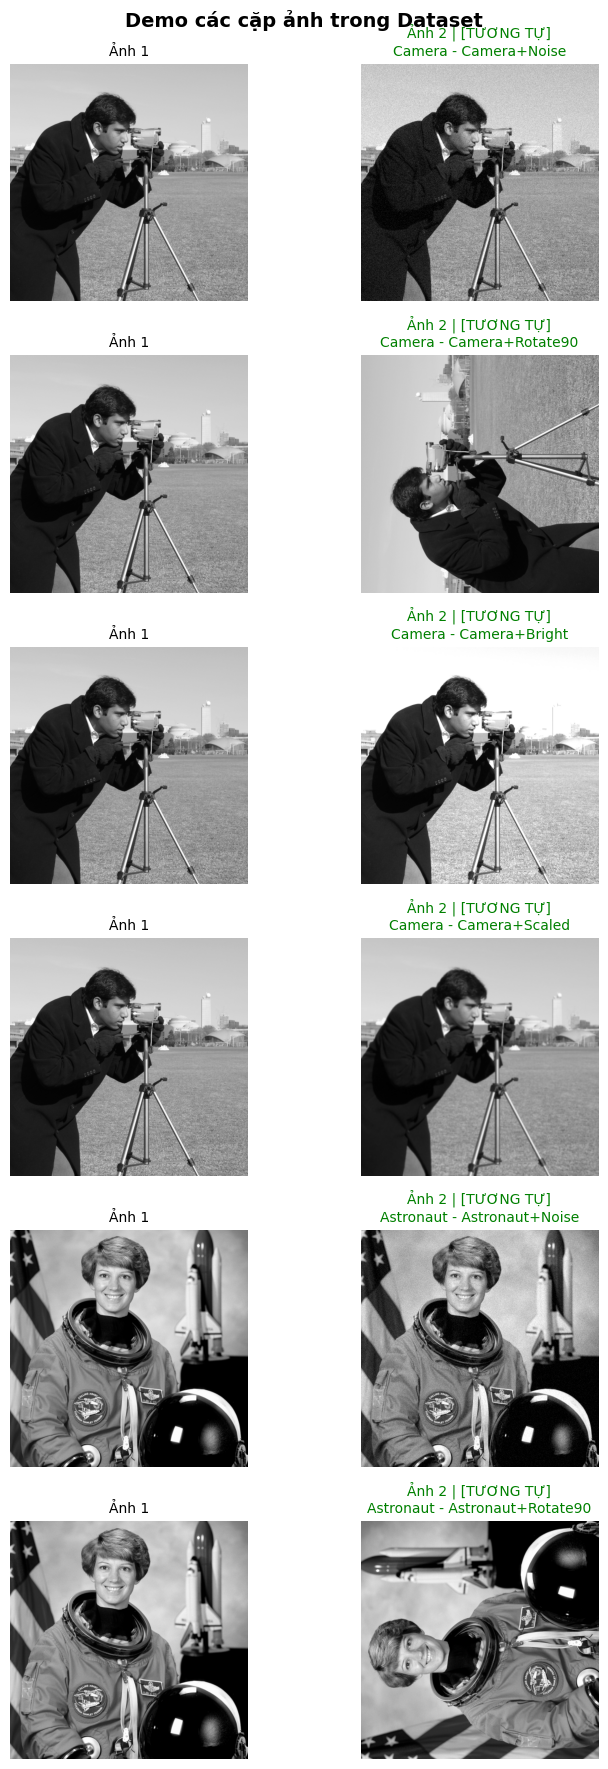

In [4]:
# ========================================
# HIỂN THỊ MỘT SỐ CẶP ẢNH MẪU
# ========================================

def display_sample_pairs(image_pairs, labels, num_samples=6, save_path=None):
    """Hiển thị một số cặp ảnh mẫu"""
    n_pairs = min(num_samples, len(image_pairs))
    
    fig, axes = plt.subplots(n_pairs, 2, figsize=(8, 3 * n_pairs))
    if n_pairs == 1:
        axes = axes.reshape(1, 2)
    
    for idx in range(n_pairs):
        img1, img2, desc = image_pairs[idx]
        label = labels[idx]
        label_text = "TƯƠNG TỰ" if label == 1 else "KHÔNG TƯƠNG TỰ"
        color = 'green' if label == 1 else 'red'
        
        # Load ảnh nếu là path
        if isinstance(img1, str):
            img1 = load_and_preprocess(img1)
        if isinstance(img2, str):
            img2 = load_and_preprocess(img2)
        
        # Hiển thị
        axes[idx, 0].imshow(img1 if len(img1.shape) == 3 else img1, cmap='gray')
        axes[idx, 0].set_title(f'Ảnh 1', fontsize=10)
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(img2 if len(img2.shape) == 3 else img2, cmap='gray')
        axes[idx, 1].set_title(f'Ảnh 2 | [{label_text}]\n{desc}', fontsize=10, color=color)
        axes[idx, 1].axis('off')
    
    plt.suptitle('Demo các cặp ảnh trong Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"[OK] Đã lưu: {save_path}")
    
    plt.show()

# Hiển thị
display_sample_pairs(
    image_pairs, labels, 
    num_samples=6,
    save_path=FIGURES_DIR / "sample_pairs.png"
)

## II.2 - Trích xuất wavelet đặc biệt

Sử dụng wavelet biến đổi để chuyển đổi từng hình ảnh thành một wavelet ma trận (coefficients).

### Discrete Wavelet Transform (DWT) 2D

PyWavelets cung cấp hàm `pywt.wavedec2()` để phân rã ảnh thành các thành phần tần số:

- **cA (Approximation)**: Thành phần tần số thấp - chứa thông tin chính của ảnh, ổn định nhất
- **cH (Horizontal detail)**: Chi tiết theo chiều ngang - phát hiện các cạnh ngang
- **cV (Vertical detail)**: Chi tiết theo chiều dọc - phát hiện các cạnh dọc
- **cD (Diagonal detail)**: Chi tiết theo đường chéo - phát hiện các cạnh chéo

### Lựa chọn wavelet và level

| Wavelet | Đặc điểm |
|---------|----------|
| `haar` | Đơn giản nhất, tốc độ nhanh |
| `db2`, `db4` | Daubechies, cân bằng giữa chi tiết và tốc độ |
| `sym2`, `sym4` | Symlets, đối xứng hơn |
| `coif1` | Coiflets, smooth hơn |

In [5]:
# ========================================
# CẤU HÌNH WAVELET HASH
# ========================================

# Cấu hình mặc định - có thể thay đổi để thử nghiệm
CONFIG = WaveletHashConfig(
    wavelet="haar",      # Loại wavelet: haar, db2, db4, sym2, coif1, ...
    level=2,             # Số cấp phân rã: 1-4 (cao hơn = ổn định hơn nhưng mất chi tiết)
    subband_mode="LL",   # Chế độ lấy subband: LL, LL_LH, LL_HL, LL_LH_HL, ALL
    quant_method="median",  # Phương pháp lượng tử: median, mean, ternary
    hash_bits=256,       # Độ dài hash (bit)
    image_size=(256, 256)  # Kích thước chuẩn hóa ảnh
)

print("[INFO] Cấu hình Wavelet Hash:")
print(f"  - Wavelet: {CONFIG.wavelet}")
print(f"  - Level: {CONFIG.level}")
print(f"  - Subband mode: {CONFIG.subband_mode}")
print(f"  - Quantization: {CONFIG.quant_method}")
print(f"  - Hash bits: {CONFIG.hash_bits}")
print(f"  - Image size: {CONFIG.image_size}")

[INFO] Cấu hình Wavelet Hash:
  - Wavelet: haar
  - Level: 2
  - Subband mode: LL
  - Quantization: median
  - Hash bits: 256
  - Image size: (256, 256)


In [6]:
# ========================================
# DEMO: PHÂN RÃ WAVELET 2D
# ========================================

# Lấy ảnh mẫu
sample_img = data.camera()  # 512x512 grayscale

# Chuẩn hóa
sample_arr = load_image_array(sample_img, size=CONFIG.image_size)

# Phân rã wavelet
coeffs = dwt2(sample_arr, wavelet=CONFIG.wavelet, level=CONFIG.level)

print(f"[INFO] Kết quả phân rã DWT level={CONFIG.level}:")
print(f"  - coeffs[0] (cA): shape = {coeffs[0].shape} (Approximation - LL band)")
for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
    print(f"  - coeffs[{i}] (cH, cV, cD): shapes = {cH.shape}, {cV.shape}, {cD.shape}")

[INFO] Kết quả phân rã DWT level=2:
  - coeffs[0] (cA): shape = (64, 64) (Approximation - LL band)
  - coeffs[1] (cH, cV, cD): shapes = (64, 64), (64, 64), (64, 64)
  - coeffs[2] (cH, cV, cD): shapes = (128, 128), (128, 128), (128, 128)


[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\wavelet_decomposition.png


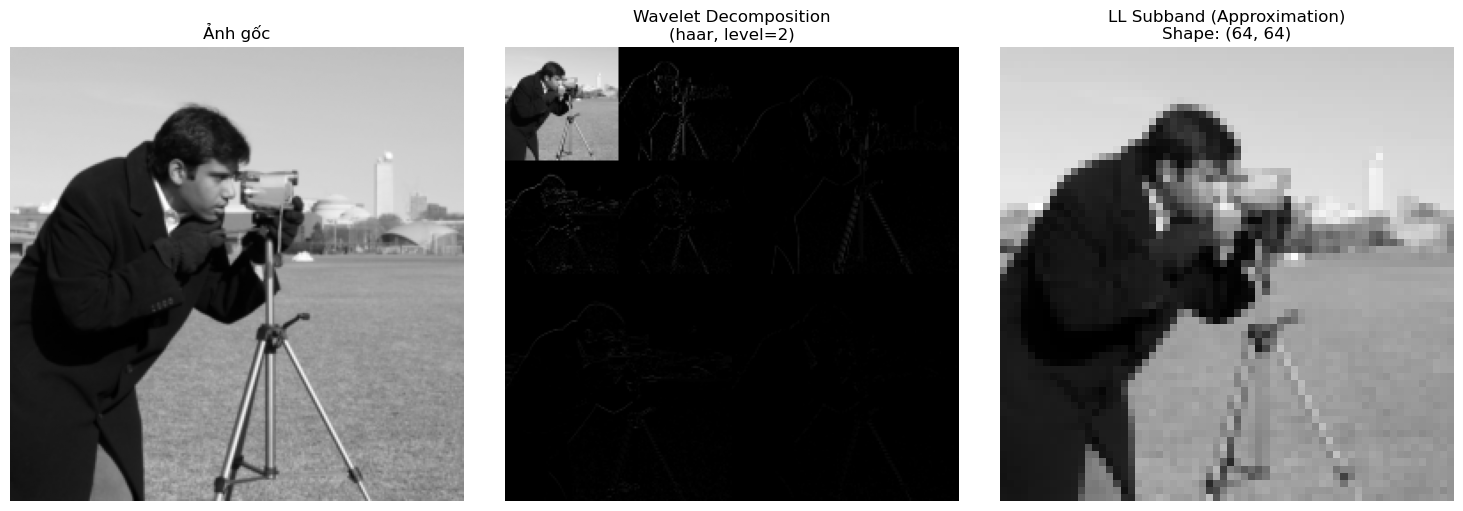


[INFO] Giải thích:
  - LL (Approximation): Thành phần tần số thấp, chứa cấu trúc chính của ảnh
  - LH (Horizontal detail): Các cạnh ngang
  - HL (Vertical detail): Các cạnh dọc
  - HH (Diagonal detail): Các cạnh chéo


In [7]:
# ========================================
# VISUALIZE WAVELET DECOMPOSITION
# ========================================

def visualize_dwt_subbands(image_arr, wavelet="haar", level=2, save_path=None):
    """Hiển thị chi tiết các subband từ DWT"""
    coeffs = dwt2(image_arr, wavelet=wavelet, level=level)
    
    # Chuyển thành array để visualize
    arr, slices = pywt.coeffs_to_array(coeffs)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Ảnh gốc
    axes[0].imshow(image_arr, cmap='gray')
    axes[0].set_title('Ảnh gốc', fontsize=12)
    axes[0].axis('off')
    
    # Tất cả coefficients
    axes[1].imshow(np.abs(arr), cmap='gray')
    axes[1].set_title(f'Wavelet Decomposition\n({wavelet}, level={level})', fontsize=12)
    axes[1].axis('off')
    
    # LL subband (approximation)
    cA = coeffs[0]
    axes[2].imshow(cA, cmap='gray')
    axes[2].set_title(f'LL Subband (Approximation)\nShape: {cA.shape}', fontsize=12)
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"[OK] Đã lưu: {save_path}")
    
    plt.show()
    
    # In thông tin thêm
    print(f"\n[INFO] Giải thích:")
    print(f"  - LL (Approximation): Thành phần tần số thấp, chứa cấu trúc chính của ảnh")
    print(f"  - LH (Horizontal detail): Các cạnh ngang")
    print(f"  - HL (Vertical detail): Các cạnh dọc")
    print(f"  - HH (Diagonal detail): Các cạnh chéo")

visualize_dwt_subbands(
    sample_arr, 
    wavelet=CONFIG.wavelet, 
    level=CONFIG.level,
    save_path=FIGURES_DIR / "wavelet_decomposition.png"
)

## II.3 - Tạo mã băm wavelet

Tạo mã băm cho mỗi hình ảnh dựa trên các wavelet số đã lượng tử hóa.

### Quy trình lượng tử hóa

1. **Lấy feature vector** từ subband đã chọn (thường là LL)
2. **Áp dụng ngưỡng** để chuyển thành bit:
   - `median`: bit = 1 nếu value > median(vector), ngược lại = 0
   - `mean`: bit = 1 nếu value > mean(vector)
   - `ternary`: Sử dụng MAD (Median Absolute Deviation) để có robust hơn
3. **Chuẩn hóa độ dài** về hash_bits (256 bits thường dùng)

[INFO] Kết quả Wavelet Hash:
  - Hash (hex): fffffffffffffbbbbbbbbf9901001023... (64 chars)
  - Hash bits length: 256
  - Subband shape: (64, 64)
  - Feature vector length: 4096


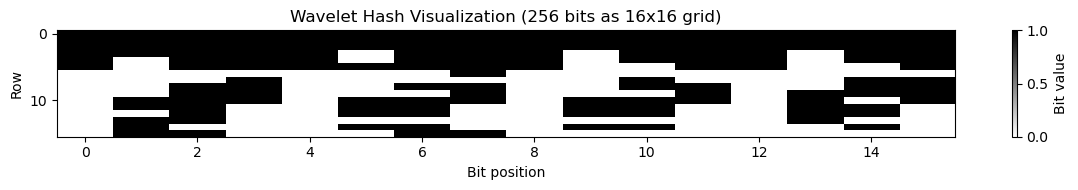

In [8]:
# ========================================
# DEMO: TẠO WAVELET HASH
# ========================================

# Tính hash cho ảnh mẫu
hash_result = wavelet_hash(sample_img, config=CONFIG)

print("[INFO] Kết quả Wavelet Hash:")
print(f"  - Hash (hex): {hash_result['hash_hex'][:32]}... ({len(hash_result['hash_hex'])} chars)")
print(f"  - Hash bits length: {len(hash_result['hash_bits'])}")
print(f"  - Subband shape: {hash_result['subband_shape']}")
print(f"  - Feature vector length: {hash_result['feature_vector_length']}")

# Visualize hash bits
plt.figure(figsize=(12, 2))
plt.imshow(hash_result['hash_bits'].reshape(16, -1), cmap='binary', aspect='auto')
plt.title('Wavelet Hash Visualization (256 bits as 16x16 grid)')
plt.xlabel('Bit position')
plt.ylabel('Row')
plt.colorbar(label='Bit value')
plt.tight_layout()
plt.show()

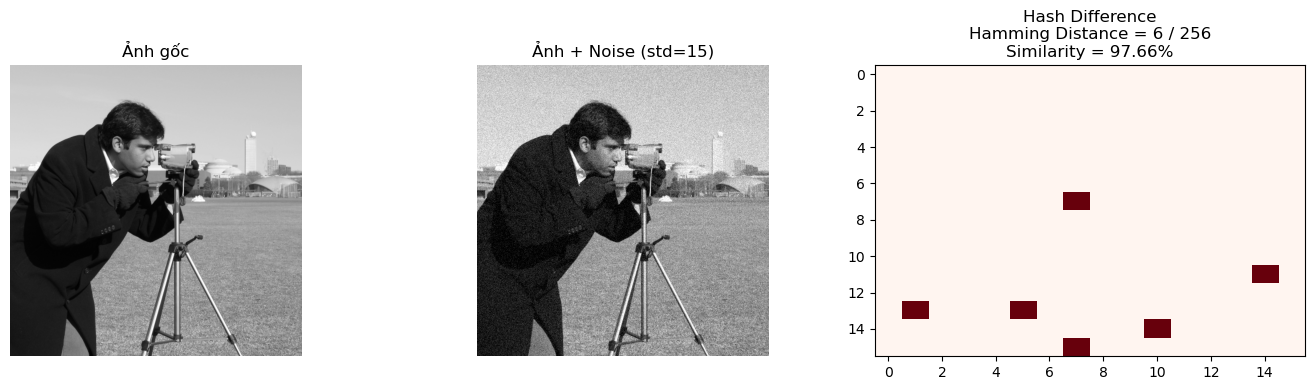


[OK] Kết luận: 2 ảnh có Hamming distance = 6 (97.66% giống nhau)
  -> Ảnh tương tự với nhau (khoảng cách nhỏ)


In [9]:
# ========================================
# DEMO: SO SÁNH HASH CỦA 2 ẢNH TƯƠNG TỰ
# ========================================

# Tạo 2 biến thể của cùng 1 ảnh
img_original = data.camera()
img_noisy = (img_original.astype(np.float32) + np.random.normal(0, 15, img_original.shape))
img_noisy = np.clip(img_noisy, 0, 255).astype(np.uint8)

# Tính hash
hash1 = wavelet_hash(img_original, config=CONFIG)
hash2 = wavelet_hash(img_noisy, config=CONFIG)

# Tính khoảng cách Hamming
dist = hamming_distance(hash1['hash_bits'], hash2['hash_bits'])
similarity = 1 - (dist / CONFIG.hash_bits)

# Hiển thị
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Ảnh gốc')
axes[0].axis('off')

axes[1].imshow(img_noisy, cmap='gray')
axes[1].set_title('Ảnh + Noise (std=15)')
axes[1].axis('off')

# So sánh hash
hash_diff = (hash1['hash_bits'] != hash2['hash_bits']).astype(int).reshape(16, -1)
axes[2].imshow(hash_diff, cmap='Reds', aspect='auto')
axes[2].set_title(f'Hash Difference\nHamming Distance = {dist} / {CONFIG.hash_bits}\nSimilarity = {similarity:.2%}')

plt.tight_layout()
plt.show()

print(f"\n[OK] Kết luận: 2 ảnh có Hamming distance = {dist} ({similarity:.2%} giống nhau)")
print(f"  -> Ảnh tương tự với nhau (khoảng cách nhỏ)")

## II.4 - So sánh hàm băm (Hamming Distance)

Tính khoảng cách Hamming giữa các mã băm để đánh giá mức độ tương thích giữa các hình ảnh.

**Khoảng cách Hamming** = Số bit khác nhau giữa 2 hash

| Hamming Distance | Mức độ tương đồng |
|-----------------|-------------------|
| 0 - 20 | Rất giống (cùng ảnh/biến thể nhẹ) |
| 20 - 50 | Tương tự |
| 50 - 100 | Có liên quan |
| > 100 | Khác nhau |

In [10]:
# ========================================
# TÍNH KHOẢNG CÁCH HAMMING CHO TẤT CẢ CÁC CẶP
# ========================================

print("[INFO] Đang tính hash và khoảng cách Hamming cho tất cả cặp ảnh...")

distances = []
pair_info = []

for idx, (img1, img2, desc) in enumerate(image_pairs):
    # Tính hash
    h1 = wavelet_hash(img1, config=CONFIG)
    h2 = wavelet_hash(img2, config=CONFIG)
    
    # Tính khoảng cách Hamming
    dist = hamming_distance(h1['hash_bits'], h2['hash_bits'])
    
    distances.append(dist)
    pair_info.append({
        'pair_id': idx,
        'description': desc,
        'label': labels[idx],
        'distance': dist,
        'similarity': 1 - dist / CONFIG.hash_bits
    })
    
    # In tiến trình
    label_str = "Similar" if labels[idx] == 1 else "Different"
    print(f"  [{idx+1:2d}/{len(image_pairs)}] {desc[:35]:35s} | Dist={dist:3d} | {label_str}")

distances = np.array(distances)

# Lưu kết quả
df_distances = pd.DataFrame(pair_info)
df_distances.to_csv(TABLES_DIR / "distances.csv", index=False)
print(f"\n[OK] Đã lưu kết quả: {TABLES_DIR / 'distances.csv'}")

[INFO] Đang tính hash và khoảng cách Hamming cho tất cả cặp ảnh...
  [ 1/20] Camera - Camera+Noise               | Dist=  4 | Similar
  [ 2/20] Camera - Camera+Rotate90            | Dist=121 | Similar
  [ 3/20] Camera - Camera+Bright              | Dist=  4 | Similar
  [ 4/20] Camera - Camera+Scaled              | Dist=  2 | Similar
  [ 5/20] Astronaut - Astronaut+Noise         | Dist=  1 | Similar
  [ 6/20] Astronaut - Astronaut+Rotate90      | Dist=133 | Similar
  [ 7/20] Moon - Moon+Noise                   | Dist= 16 | Similar
  [ 8/20] Moon - Moon+Dark                    | Dist=  1 | Similar
  [ 9/20] Coins - Coins+Noise                 | Dist=  4 | Similar
  [10/20] Coins - Coins+Bright                | Dist=  0 | Similar
  [11/20] Camera - Astronaut                  | Dist=147 | Different
  [12/20] Camera - Coins                      | Dist=107 | Different
  [13/20] Camera - Moon                       | Dist=104 | Different
  [14/20] Camera - Text                       | Dist=141

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\distance_distribution.png


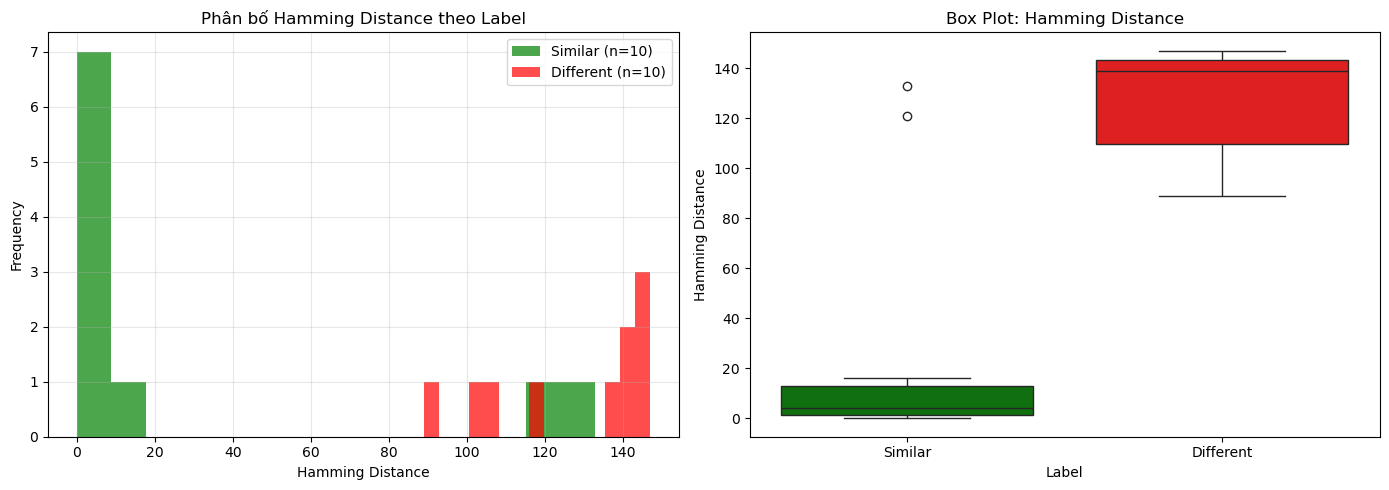


[INFO] Thống kê Hamming Distance:
  Similar pairs:   mean=28.6, std=49.5, range=[0, 133]
  Different pairs: mean=127.4, std=20.0, range=[89, 147]


In [11]:
# ========================================
# VISUALIZE PHÂN BỐ KHOẢNG CÁCH
# ========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram theo label
similar_dists = distances[labels == 1]
different_dists = distances[labels == 0]

axes[0].hist(similar_dists, bins=15, alpha=0.7, label=f'Similar (n={len(similar_dists)})', color='green')
axes[0].hist(different_dists, bins=15, alpha=0.7, label=f'Different (n={len(different_dists)})', color='red')
axes[0].set_xlabel('Hamming Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Phân bố Hamming Distance theo Label')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
df_plot = pd.DataFrame({
    'Distance': distances,
    'Label': ['Similar' if l == 1 else 'Different' for l in labels]
})
sns.boxplot(data=df_plot, x='Label', y='Distance', ax=axes[1], palette=['green', 'red'])
axes[1].set_title('Box Plot: Hamming Distance')
axes[1].set_ylabel('Hamming Distance')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "distance_distribution.png", dpi=150, bbox_inches='tight')
print(f"[OK] Đã lưu: {FIGURES_DIR / 'distance_distribution.png'}")
plt.show()

# Thống kê
print(f"\n[INFO] Thống kê Hamming Distance:")
print(f"  Similar pairs:   mean={similar_dists.mean():.1f}, std={similar_dists.std():.1f}, range=[{similar_dists.min()}, {similar_dists.max()}]")
print(f"  Different pairs: mean={different_dists.mean():.1f}, std={different_dists.std():.1f}, range=[{different_dists.min()}, {different_dists.max()}]")

## II.5 - Đánh giá

Đánh giá hiệu suất thuật toán thông qua các metrics:

- **Độ chính xác (Accuracy)**: Tỷ lệ tính toán của các cặp hình ảnh được phân loại đúng (tương tự/không tương tự)
- **Độ nhạy (Sensitivity/Recall/TPR)**: Tỷ lệ các cặp hình ảnh tương thích được phân loại đúng
- **Độ đặc biệt (Specificity/TNR)**: Tỷ lệ tính toán của các cặp hình ảnh không tương thích với loại phân tích đúng
- **Đường cong ROC**: Vẽ đường cong ROC để đánh giá hiệu suất của thuật toán

In [12]:
# ========================================
# TÌM NGƯỠNG TỐI ƯU
# ========================================

# Tìm ngưỡng tối ưu theo Accuracy
optimal_result = find_optimal_threshold(
    distances, labels, 
    criterion="accuracy",  # có thể đổi thành "youden" hoặc "f1"
    num_thresholds=100
)

print("="*70)
print("KẾT QUẢ ĐÁNH GIÁ TẠI NGƯỠNG TỐI ƯU")
print("="*70)
print(f"\nNgưỡng tối ưu: {optimal_result['threshold']:.2f}")
print(f"Tiêu chí: {optimal_result['criterion']}")
print(f"\n{'Metric':<20} {'Giá trị':<15} {'Ý nghĩa'}")
print("-"*70)
print(f"{'Accuracy':<20} {optimal_result['accuracy']:.4f} ({optimal_result['accuracy']*100:.2f}%)     Tỷ lệ phân loại đúng")
print(f"{'Sensitivity (TPR)':<20} {optimal_result['sensitivity']:.4f} ({optimal_result['sensitivity']*100:.2f}%)     Phát hiện cặp tương tự")
print(f"{'Specificity (TNR)':<20} {optimal_result['specificity']:.4f} ({optimal_result['specificity']*100:.2f}%)     Phát hiện cặp khác nhau")
print(f"{'Precision':<20} {optimal_result['precision']:.4f} ({optimal_result['precision']*100:.2f}%)     Độ chính xác dự đoán")
print(f"{'F1-Score':<20} {optimal_result['f1_score']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Positive (TP):  {optimal_result['TP']:3d}")
print(f"  True Negative (TN):  {optimal_result['TN']:3d}")
print(f"  False Positive (FP): {optimal_result['FP']:3d}")
print(f"  False Negative (FN): {optimal_result['FN']:3d}")
print("="*70)

KẾT QUẢ ĐÁNH GIÁ TẠI NGƯỠNG TỐI ƯU

Ngưỡng tối ưu: 16.33
Tiêu chí: accuracy

Metric               Giá trị         Ý nghĩa
----------------------------------------------------------------------
Accuracy             0.9000 (90.00%)     Tỷ lệ phân loại đúng
Sensitivity (TPR)    0.8000 (80.00%)     Phát hiện cặp tương tự
Specificity (TNR)    1.0000 (100.00%)     Phát hiện cặp khác nhau
Precision            1.0000 (100.00%)     Độ chính xác dự đoán
F1-Score             0.8889

Confusion Matrix:
  True Positive (TP):    8
  True Negative (TN):   10
  False Positive (FP):   0
  False Negative (FN):   2


[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\confusion_matrix.png


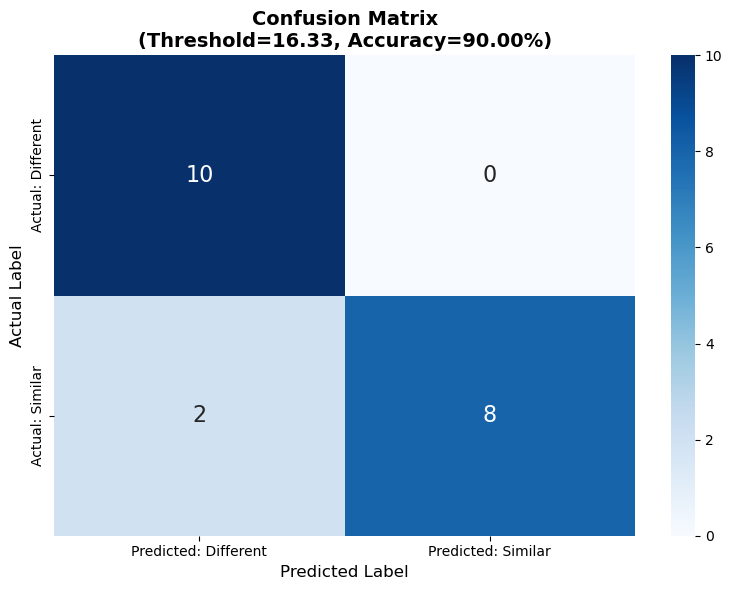

In [13]:
# ========================================
# VẼ CONFUSION MATRIX
# ========================================

fig, ax = plt.subplots(figsize=(8, 6))

cm = np.array([
    [optimal_result['TN'], optimal_result['FP']],
    [optimal_result['FN'], optimal_result['TP']]
])

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Predicted: Different', 'Predicted: Similar'],
    yticklabels=['Actual: Different', 'Actual: Similar'],
    annot_kws={'size': 16},
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title(
    f'Confusion Matrix\n(Threshold={optimal_result["threshold"]:.2f}, Accuracy={optimal_result["accuracy"]:.2%})',
    fontsize=14, fontweight='bold'
)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "confusion_matrix.png", dpi=150, bbox_inches='tight')
print(f"[OK] Đã lưu: {FIGURES_DIR / 'confusion_matrix.png'}")
plt.show()

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\roc_curve.png


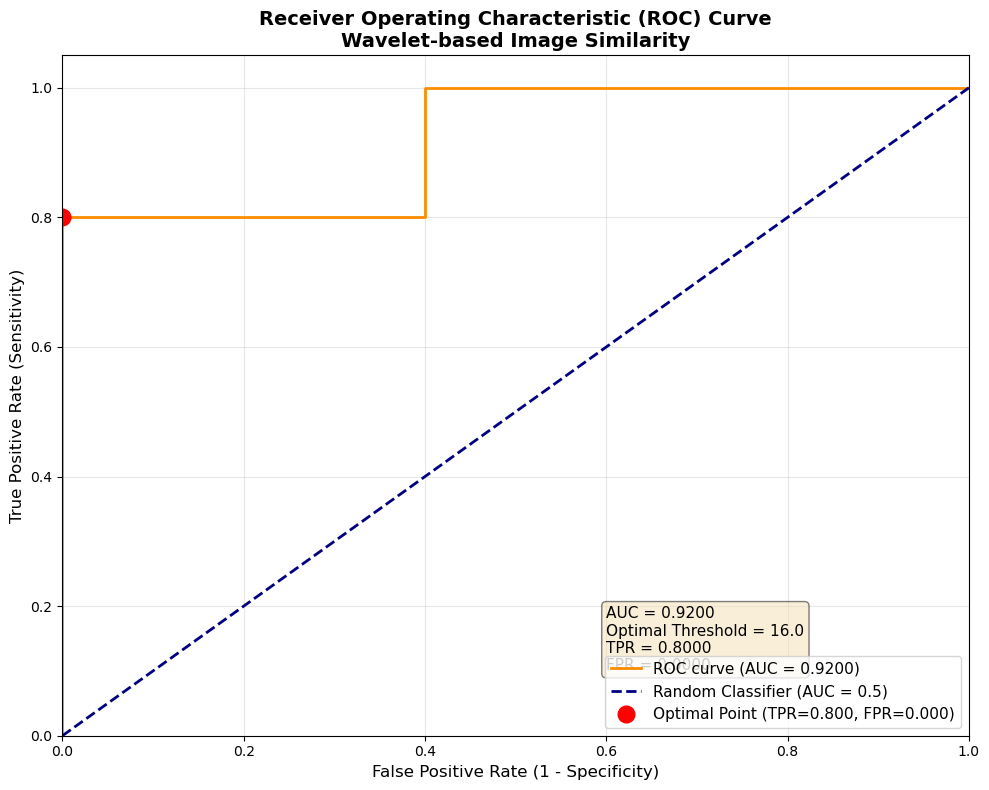


[INFO] Đánh giá AUC:
  AUC = 0.9200 -> Xuất sắc (Excellent)


In [14]:
# ========================================
# VẼ ĐƯỜNG CONG ROC
# ========================================

# Tính ROC curve
roc_data = compute_roc_auc(distances, labels)

fig, ax = plt.subplots(figsize=(10, 8))

# Vẽ ROC curve
ax.plot(
    roc_data['fpr'], roc_data['tpr'],
    color='darkorange', lw=2,
    label=f"ROC curve (AUC = {roc_data['auc']:.4f})"
)

# Đường tham chiếu (random classifier)
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')

# Điểm tối ưu
ax.plot(
    roc_data['optimal_fpr'], roc_data['optimal_tpr'],
    'ro', markersize=12,
    label=f"Optimal Point (TPR={roc_data['optimal_tpr']:.3f}, FPR={roc_data['optimal_fpr']:.3f})"
)

ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('Receiver Operating Characteristic (ROC) Curve\nWavelet-based Image Similarity', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

# Text box với thông tin
textstr = f"AUC = {roc_data['auc']:.4f}\nOptimal Threshold = {roc_data['optimal_threshold']:.1f}\nTPR = {roc_data['optimal_tpr']:.4f}\nFPR = {roc_data['optimal_fpr']:.4f}"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.6, 0.2, textstr, fontsize=11, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "roc_curve.png", dpi=150, bbox_inches='tight')
print(f"[OK] Đã lưu: {FIGURES_DIR / 'roc_curve.png'}")
plt.show()

# Giải thích AUC
print(f"\n[INFO] Đánh giá AUC:")
if roc_data['auc'] >= 0.9:
    print(f"  AUC = {roc_data['auc']:.4f} -> Xuất sắc (Excellent)")
elif roc_data['auc'] >= 0.8:
    print(f"  AUC = {roc_data['auc']:.4f} -> Tốt (Good)")
elif roc_data['auc'] >= 0.7:
    print(f"  AUC = {roc_data['auc']:.4f} -> Khá (Fair)")
else:
    print(f"  AUC = {roc_data['auc']:.4f} -> Cần cải thiện (Poor)")

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\metrics_vs_threshold.png


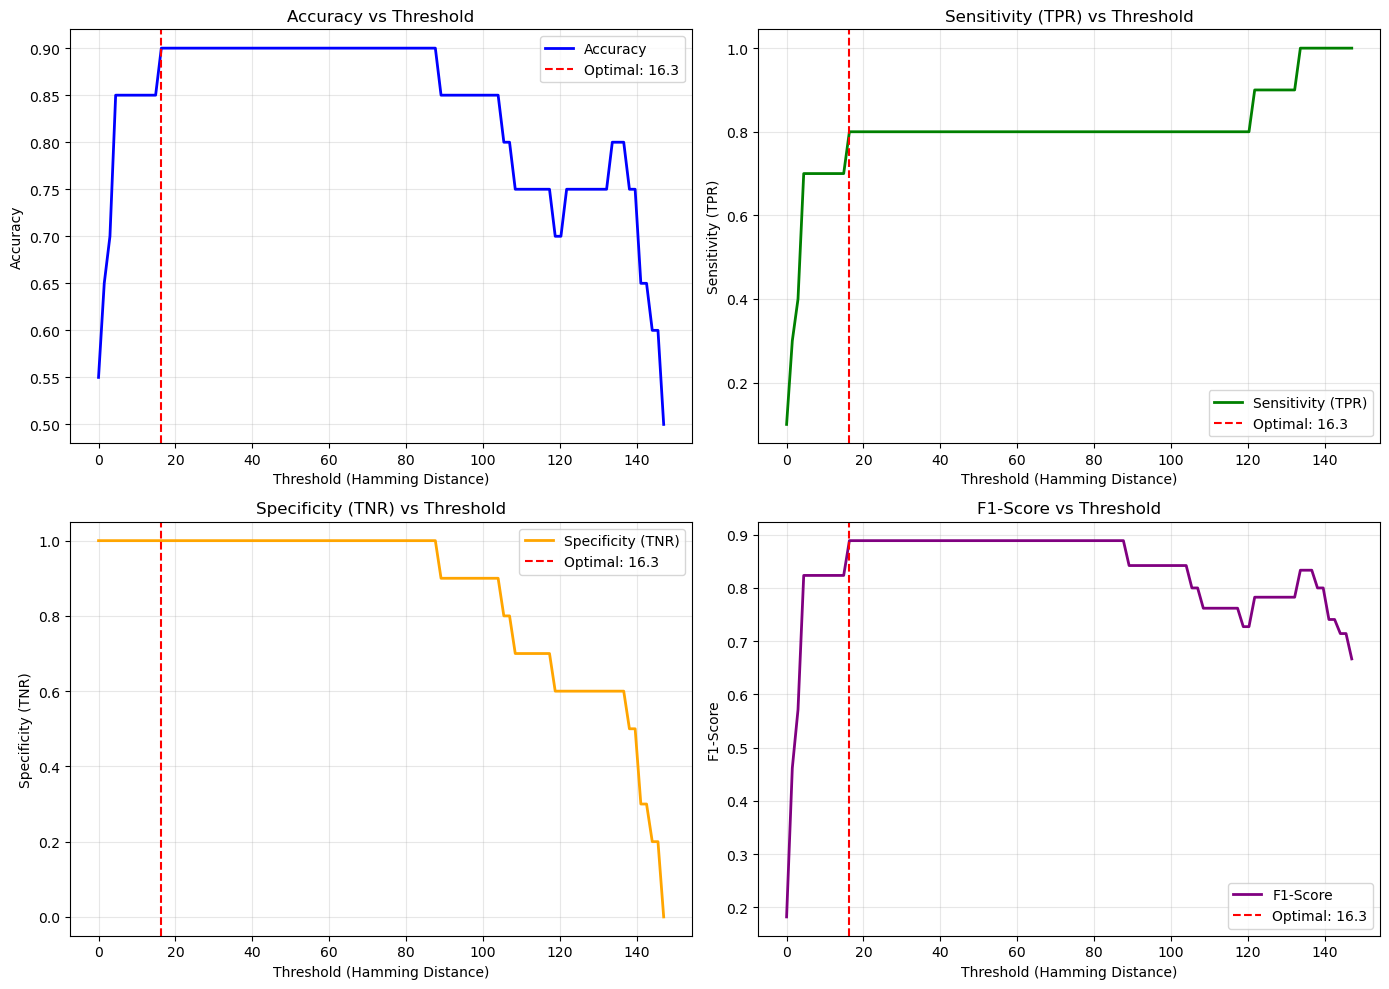

In [15]:
# ========================================
# VẼ METRICS VS THRESHOLD
# ========================================

all_metrics = optimal_result['all_metrics']
thresholds = optimal_result['all_thresholds']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics_to_plot = [
    ('accuracy', 'Accuracy', 'blue'),
    ('sensitivity', 'Sensitivity (TPR)', 'green'),
    ('specificity', 'Specificity (TNR)', 'orange'),
    ('f1_score', 'F1-Score', 'purple')
]

for ax, (metric_key, metric_name, color) in zip(axes, metrics_to_plot):
    values = [m[metric_key] for m in all_metrics]
    
    ax.plot(thresholds, values, color=color, linewidth=2, label=metric_name)
    ax.axvline(optimal_result['threshold'], color='red', linestyle='--', label=f"Optimal: {optimal_result['threshold']:.1f}")
    
    ax.set_xlabel('Threshold (Hamming Distance)')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} vs Threshold')
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "metrics_vs_threshold.png", dpi=150, bbox_inches='tight')
print(f"[OK] Đã lưu: {FIGURES_DIR / 'metrics_vs_threshold.png'}")
plt.show()

---

# III> Bài tập nâng cao

## III.1 - So sánh các phương pháp băm wavelet

Thực hiện khảo sát về các phương pháp băm wavelet khác nhau và so sánh hiệu suất của chúng:

1. **Wavelet types**: haar, db2, db4, sym2
2. **Decomposition levels**: 1, 2, 3
3. **Quantization methods**: median, mean, ternary
4. **Subband modes**: LL, LL_LH, ALL

In [16]:
# ========================================
# ĐỊNH NGHĨA CÁC PHƯƠNG PHÁP CẦN KHẢO SÁT
# ========================================

def create_method_configs():
    """Tạo danh sách các cấu hình để khảo sát"""
    methods = []
    base_config = {
        'image_size': (256, 256),
        'hash_bits': 256
    }
    
    # A) Khảo sát Wavelet types
    for wavelet in ['haar', 'db2', 'db4', 'sym2']:
        methods.append({
            'name': f'Wavelet: {wavelet}',
            'group': 'A-Wavelet',
            'wavelet': wavelet,
            'level': 2,
            'subband_mode': 'LL',
            'quant_method': 'median',
            **base_config
        })
    
    # B) Khảo sát Decomposition levels
    for level in [1, 2, 3]:
        methods.append({
            'name': f'Level: {level}',
            'group': 'B-Level',
            'wavelet': 'haar',
            'level': level,
            'subband_mode': 'LL',
            'quant_method': 'median',
            **base_config
        })
    
    # C) Khảo sát Quantization methods
    for quant in ['median', 'mean']:
        methods.append({
            'name': f'Quant: {quant}',
            'group': 'C-Quant',
            'wavelet': 'haar',
            'level': 2,
            'subband_mode': 'LL',
            'quant_method': quant,
            **base_config
        })
    
    # D) Khảo sát Subband modes
    for subband in ['LL', 'LL_LH', 'ALL']:
        methods.append({
            'name': f'Subband: {subband}',
            'group': 'D-Subband',
            'wavelet': 'haar',
            'level': 2,
            'subband_mode': subband,
            'quant_method': 'median',
            **base_config
        })
    
    return methods

method_configs = create_method_configs()
print(f"[INFO] Tổng số phương pháp cần khảo sát: {len(method_configs)}")
print("\nDanh sách:")
for i, cfg in enumerate(method_configs, 1):
    print(f"  {i:2d}. [{cfg['group']}] {cfg['name']}")

[INFO] Tổng số phương pháp cần khảo sát: 12

Danh sách:
   1. [A-Wavelet] Wavelet: haar
   2. [A-Wavelet] Wavelet: db2
   3. [A-Wavelet] Wavelet: db4
   4. [A-Wavelet] Wavelet: sym2
   5. [B-Level] Level: 1
   6. [B-Level] Level: 2
   7. [B-Level] Level: 3
   8. [C-Quant] Quant: median
   9. [C-Quant] Quant: mean
  10. [D-Subband] Subband: LL
  11. [D-Subband] Subband: LL_LH
  12. [D-Subband] Subband: ALL


In [17]:
# ========================================
# CHẠY KHẢO SÁT VÀ ĐÁNH GIÁ
# ========================================

print("[INFO] Đang chạy khảo sát các phương pháp...\n")

comparison_results = []

for idx, cfg in enumerate(method_configs, 1):
    print(f"[{idx}/{len(method_configs)}] {cfg['name']}...", end=" ")
    
    # Tính distances cho phương pháp này
    method_distances = []
    
    for img1, img2, desc in image_pairs:
        h1 = wavelet_hash(
            img1,
            wavelet=cfg['wavelet'],
            level=cfg['level'],
            subband_mode=cfg['subband_mode'],
            quant_method=cfg['quant_method'],
            hash_bits=cfg['hash_bits'],
            image_size=cfg['image_size']
        )
        h2 = wavelet_hash(
            img2,
            wavelet=cfg['wavelet'],
            level=cfg['level'],
            subband_mode=cfg['subband_mode'],
            quant_method=cfg['quant_method'],
            hash_bits=cfg['hash_bits'],
            image_size=cfg['image_size']
        )
        
        dist = hamming_distance(h1['hash_bits'], h2['hash_bits'])
        method_distances.append(dist)
    
    method_distances = np.array(method_distances)
    
    # Tìm ngưỡng tối ưu
    opt_result = find_optimal_threshold(method_distances, labels, criterion='accuracy')
    
    # Tính ROC AUC
    roc = compute_roc_auc(method_distances, labels)
    
    result = {
        'name': cfg['name'],
        'group': cfg['group'],
        'wavelet': cfg['wavelet'],
        'level': cfg['level'],
        'subband_mode': cfg['subband_mode'],
        'quant_method': cfg['quant_method'],
        'accuracy': opt_result['accuracy'],
        'sensitivity': opt_result['sensitivity'],
        'specificity': opt_result['specificity'],
        'f1_score': opt_result['f1_score'],
        'auc': roc['auc'],
        'optimal_threshold': opt_result['threshold'],
        'distances': method_distances
    }
    
    comparison_results.append(result)
    print(f"Acc={result['accuracy']:.3f}, AUC={result['auc']:.3f}")

print("\n[OK] Hoàn thành khảo sát!")

[INFO] Đang chạy khảo sát các phương pháp...

[1/12] Wavelet: haar... Acc=0.900, AUC=0.920
[2/12] Wavelet: db2... Acc=0.900, AUC=0.900
[3/12] Wavelet: db4... Acc=0.900, AUC=0.900
[4/12] Wavelet: sym2... Acc=0.900, AUC=0.900
[5/12] Level: 1... Acc=0.950, AUC=0.970
[6/12] Level: 2... Acc=0.900, AUC=0.920
[7/12] Level: 3... Acc=0.900, AUC=0.900
[8/12] Quant: median... Acc=0.900, AUC=0.920
[9/12] Quant: mean... Acc=0.900, AUC=0.900
[10/12] Subband: LL... Acc=0.900, AUC=0.920
[11/12] Subband: LL_LH... Acc=0.800, AUC=0.770
[12/12] Subband: ALL... Acc=0.900, AUC=0.850

[OK] Hoàn thành khảo sát!


In [18]:
# ========================================
# BẢNG TỔNG KẾT KẾT QUẢ
# ========================================

# Tạo DataFrame
df_results = pd.DataFrame([{
    'Method': r['name'],
    'Group': r['group'],
    'Accuracy': r['accuracy'],
    'Sensitivity': r['sensitivity'],
    'Specificity': r['specificity'],
    'F1-Score': r['f1_score'],
    'AUC': r['auc'],
    'Threshold': r['optimal_threshold']
} for r in comparison_results])

# Sắp xếp theo AUC giảm dần
df_results = df_results.sort_values('AUC', ascending=False)

# Lưu ra CSV
df_results.to_csv(TABLES_DIR / "methods_comparison.csv", index=False)
print(f"[OK] Đã lưu: {TABLES_DIR / 'methods_comparison.csv'}\n")

# Hiển thị
print("BẢNG SO SÁNH CÁC PHƯƠNG PHÁP (sắp xếp theo AUC)")
print("="*90)
display_df = df_results.copy()
for col in ['Accuracy', 'Sensitivity', 'Specificity', 'F1-Score', 'AUC']:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}")
display_df['Threshold'] = display_df['Threshold'].apply(lambda x: f"{x:.1f}")
print(display_df.to_string(index=False))

# Highlight top 3
print(f"\n[INFO] TOP 3 PHƯƠNG PHÁP TỐT NHẤT (theo AUC):")
for i, row in df_results.head(3).iterrows():
    print(f"  {df_results.index.get_loc(i)+1}. {row['Method']}: AUC={row['AUC']:.4f}, Acc={row['Accuracy']:.4f}")

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\tables\methods_comparison.csv

BẢNG SO SÁNH CÁC PHƯƠNG PHÁP (sắp xếp theo AUC)
        Method     Group Accuracy Sensitivity Specificity F1-Score    AUC Threshold
      Level: 1   B-Level   0.9500      0.9000      1.0000   0.9474 0.9700      71.1
 Wavelet: haar A-Wavelet   0.9000      0.8000      1.0000   0.8889 0.9200      16.3
      Level: 2   B-Level   0.9000      0.8000      1.0000   0.8889 0.9200      16.3
 Quant: median   C-Quant   0.9000      0.8000      1.0000   0.8889 0.9200      16.3
   Subband: LL D-Subband   0.9000      0.8000      1.0000   0.8889 0.9200      16.3
 Wavelet: sym2 A-Wavelet   0.9000      0.8000      1.0000   0.8889 0.9000      18.0
  Wavelet: db2 A-Wavelet   0.9000      0.8000      1.0000   0.8889 0.9000      18.0
  Wavelet: db4 A-Wavelet   0.9000      0.8000      1.0000   0.8889 0.9000      31.9
      Level: 3   B-Level   0.9000      0.8

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\methods_comparison.png


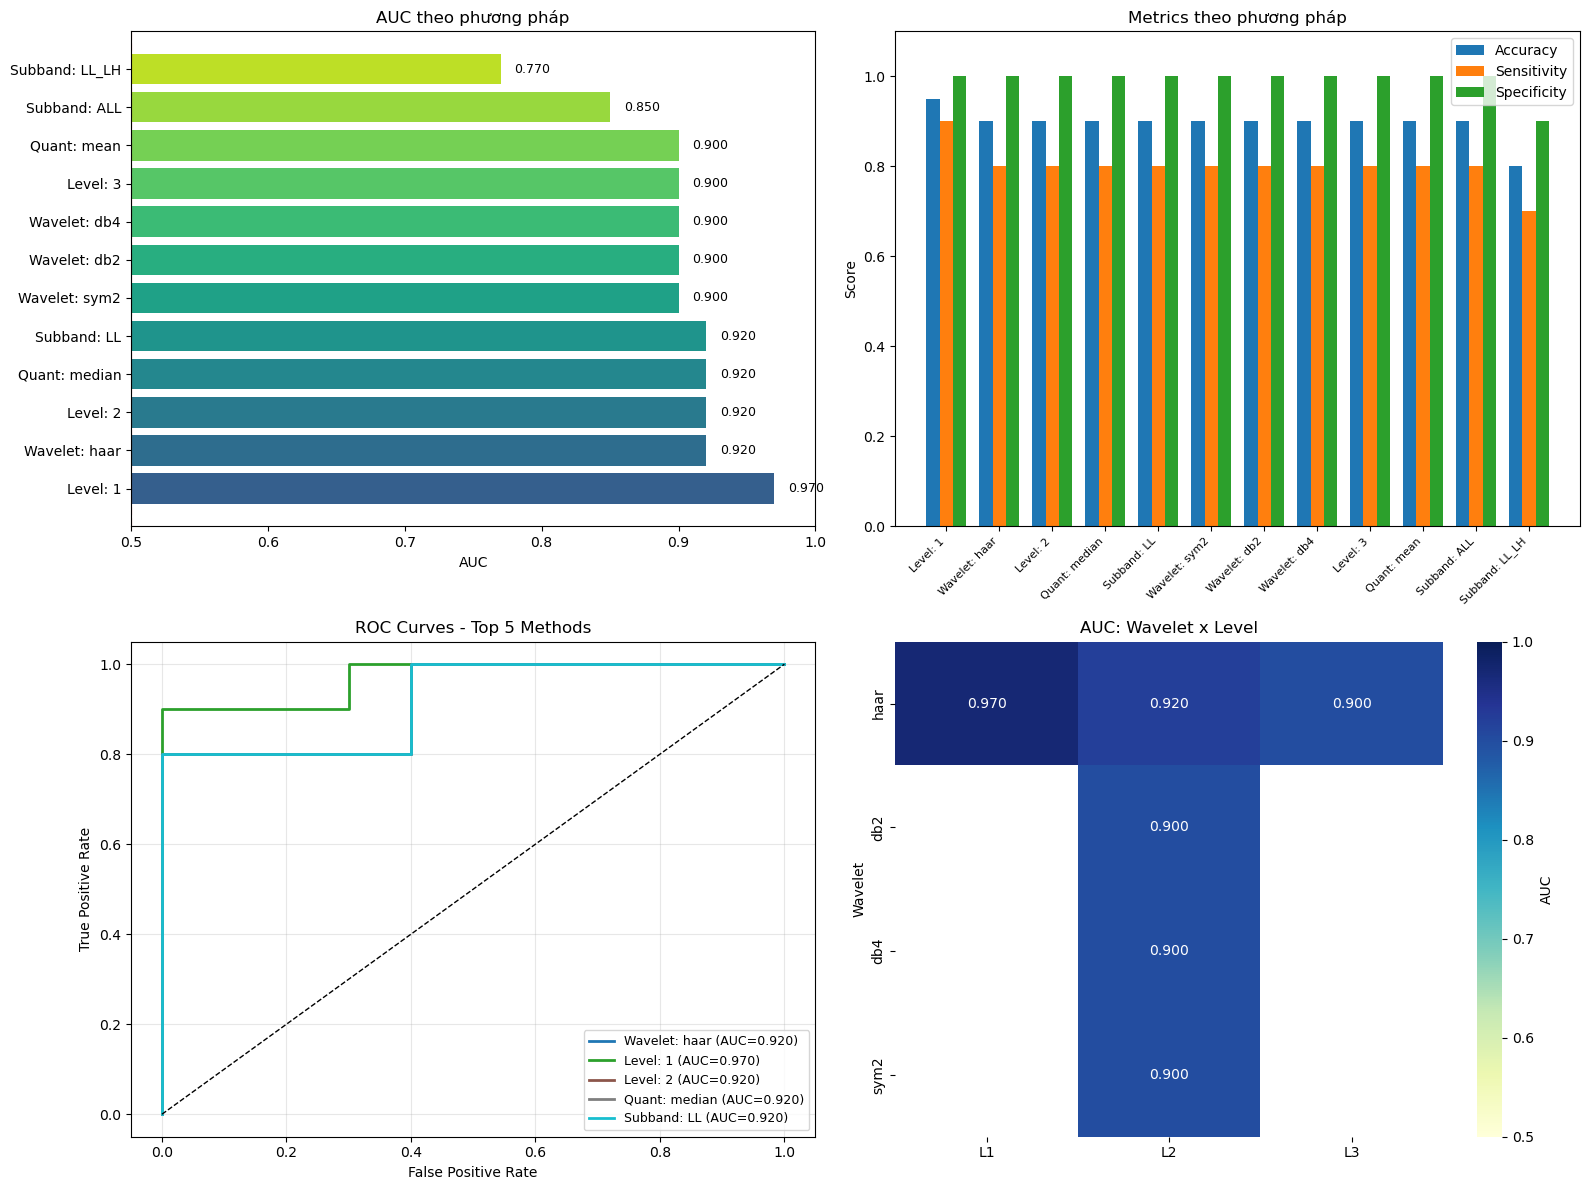

In [19]:
# ========================================
# VISUALIZE SO SÁNH
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) Bar chart: AUC theo phương pháp
ax = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(df_results)))
bars = ax.barh(df_results['Method'], df_results['AUC'], color=colors)
ax.set_xlabel('AUC')
ax.set_title('AUC theo phương pháp')
ax.set_xlim([0.5, 1.0])
ax.axvline(0.5, color='red', linestyle='--', label='Random (0.5)')
for bar, val in zip(bars, df_results['AUC']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# 2) Grouped bar: Metrics theo group
ax = axes[0, 1]
metrics_cols = ['Accuracy', 'Sensitivity', 'Specificity']
x = np.arange(len(df_results))
width = 0.25
for i, metric in enumerate(metrics_cols):
    ax.bar(x + i*width, df_results[metric], width, label=metric)
ax.set_ylabel('Score')
ax.set_title('Metrics theo phương pháp')
ax.set_xticks(x + width)
ax.set_xticklabels(df_results['Method'], rotation=45, ha='right', fontsize=8)
ax.legend()
ax.set_ylim([0, 1.1])

# 3) ROC curves cho top 5 methods
ax = axes[1, 0]
top_5 = df_results.head(5)['Method'].tolist()
colors_roc = plt.cm.tab10(np.linspace(0, 1, 5))

for result, color in zip([r for r in comparison_results if r['name'] in top_5], colors_roc):
    roc = compute_roc_auc(result['distances'], labels)
    ax.plot(roc['fpr'], roc['tpr'], lw=2, color=color, 
            label=f"{result['name']} (AUC={roc['auc']:.3f})")

ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Top 5 Methods')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

# 4) Heatmap: Performance by parameter
ax = axes[1, 1]
# Tạo pivot table cho wavelet vs level
pivot_data = []
for wavelet in ['haar', 'db2', 'db4', 'sym2']:
    row = {'Wavelet': wavelet}
    for level in [1, 2, 3]:
        matching = [r for r in comparison_results 
                   if r['wavelet'] == wavelet and r['level'] == level 
                   and r['subband_mode'] == 'LL' and r['quant_method'] == 'median']
        row[f'L{level}'] = matching[0]['auc'] if matching else np.nan
    pivot_data.append(row)

df_pivot = pd.DataFrame(pivot_data).set_index('Wavelet')
sns.heatmap(df_pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, 
            vmin=0.5, vmax=1.0, cbar_kws={'label': 'AUC'})
ax.set_title('AUC: Wavelet x Level')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "methods_comparison.png", dpi=150, bbox_inches='tight')
print(f"[OK] Đã lưu: {FIGURES_DIR / 'methods_comparison.png'}")
plt.show()

### Kết luận so sánh phương pháp

Dựa trên kết quả khảo sát:

1. **Wavelet type**: Các wavelet phức tạp hơn (db2, db4) thường cho kết quả tốt hơn haar trong nhiều trường hợp
2. **Decomposition level**: Level 2 thường là lựa chọn cân bằng tốt giữa độ ổn định và chi tiết
3. **Quantization**: Median thresholding thường robust hơn mean
4. **Subband**: LL band đủ tốt cho hầu hết trường hợp, thêm các band khác có thể cải thiện nhưng tăng complexity

## III.2 - Ứng dụng tìm kiếm hình ảnh (Image Retrieval)

Xây dựng ứng dụng tìm kiếm hình ảnh dựa trên hàm băm wavelet:

1. **Build Gallery**: Tính hash cho toàn bộ database ảnh
2. **Query**: Cho ảnh query, tính hash và tìm top-k ảnh gần nhất trong gallery
3. **Display**: Hiển thị kết quả với khoảng cách và độ tương đồng

In [20]:
# ========================================
# TẠO GALLERY TỪ SKIMAGE DATASET
# ========================================

print("[INFO] Đang xây dựng Gallery từ ảnh mẫu...")

# Load tất cả ảnh mẫu từ skimage
gallery_images = {
    'camera': data.camera(),
    'astronaut': (0.299 * data.astronaut()[:,:,0] + 0.587 * data.astronaut()[:,:,1] + 0.114 * data.astronaut()[:,:,2]).astype(np.uint8),
    'coins': data.coins(),
    'moon': data.moon(),
    'text': data.text(),
    'coffee': data.coffee()[:,:,0] if len(data.coffee().shape) == 3 else data.coffee(),
    'clock': data.clock(),
    'horse': data.horse().astype(np.uint8) * 255,
}

# Thêm các biến thể
gallery_images['camera_noisy'] = np.clip(
    gallery_images['camera'].astype(np.float32) + np.random.normal(0, 15, gallery_images['camera'].shape),
    0, 255
).astype(np.uint8)

gallery_images['camera_bright'] = np.clip(
    gallery_images['camera'].astype(np.float32) * 1.3,
    0, 255
).astype(np.uint8)

gallery_images['moon_dark'] = np.clip(
    gallery_images['moon'].astype(np.float32) * 0.7,
    0, 255
).astype(np.uint8)

# Build gallery
gallery = build_hash_gallery_from_arrays(
    images=list(gallery_images.values()),
    names=list(gallery_images.keys()),
    config=CONFIG
)

print(f"\n[OK] Gallery đã sẵn sàng với {len(gallery)} ảnh:")
for name in gallery.keys():
    print(f"  - {name}")

[INFO] Đang xây dựng Gallery từ ảnh mẫu...

[OK] Gallery đã sẵn sàng với 11 ảnh:
  - camera
  - astronaut
  - coins
  - moon
  - text
  - coffee
  - clock
  - horse
  - camera_noisy
  - camera_bright
  - moon_dark


In [21]:
# ========================================
# DEMO: TÌM KIẾM ẢNH TƯƠNG TỰ
# ========================================

def image_retrieval_demo(query_img, query_name, gallery, top_k=5, save_path=None):
    """
    Demo tìm kiếm ảnh tương tự.
    
    Parameters
    ----------
    query_img : np.ndarray
        Ảnh query.
    query_name : str
        Tên ảnh query.
    gallery : dict
        Gallery hash.
    top_k : int
        Số lượng kết quả.
    save_path : str
        Đường dẫn lưu hình.
    """
    # Tính hash query
    query_hash = wavelet_hash(query_img, config=CONFIG)
    
    # Tìm kiếm
    results = []
    for name, hash_result in gallery.items():
        dist = hamming_distance(query_hash['hash_bits'], hash_result['hash_bits'])
        similarity = 1 - dist / CONFIG.hash_bits
        results.append((name, dist, similarity))
    
    # Sắp xếp theo distance
    results.sort(key=lambda x: x[1])
    top_results = results[:top_k]
    
    # Hiển thị
    n_cols = top_k + 1
    fig, axes = plt.subplots(1, n_cols, figsize=(3 * n_cols, 4))
    
    # Query
    axes[0].imshow(query_img, cmap='gray')
    axes[0].set_title(f'QUERY\n{query_name}', fontsize=11, fontweight='bold', color='blue')
    axes[0].axis('off')
    
    # Kết quả
    for i, (name, dist, sim) in enumerate(top_results):
        ax = axes[i + 1]
        
        # Lấy ảnh từ gallery
        img = gallery_images[name]
        ax.imshow(img, cmap='gray')
        
        # Màu theo độ tương tự
        color = 'green' if sim > 0.8 else 'orange' if sim > 0.6 else 'red'
        
        ax.set_title(f'#{i+1}: {name}\nDist={dist}, Sim={sim:.1%}', 
                    fontsize=10, color=color)
        ax.axis('off')
    
    plt.suptitle(f'Image Retrieval Results (Top-{top_k})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"[OK] Đã lưu: {save_path}")
    
    plt.show()
    
    # In kết quả dạng text
    print(f"\n[INFO] Kết quả tìm kiếm cho '{query_name}':")
    for rank, (name, dist, sim) in enumerate(top_results, 1):
        print(f"  {rank}. {name:20s} | Distance: {dist:3d} | Similarity: {sim:.2%}")

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\retrieval_demo_camera.png


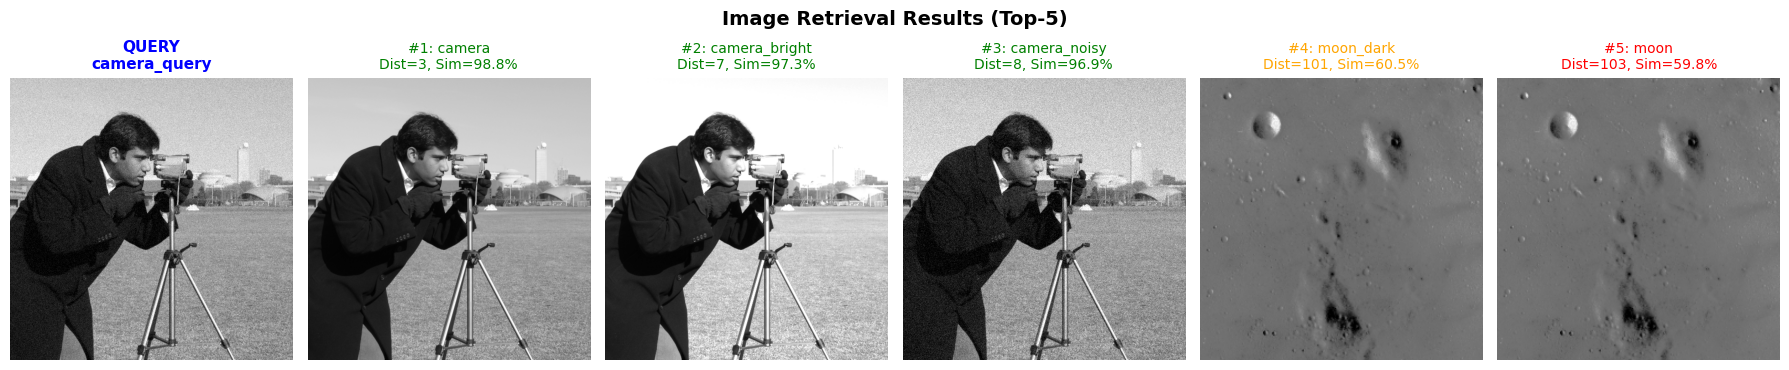


[INFO] Kết quả tìm kiếm cho 'camera_query':
  1. camera               | Distance:   3 | Similarity: 98.83%
  2. camera_bright        | Distance:   7 | Similarity: 97.27%
  3. camera_noisy         | Distance:   8 | Similarity: 96.88%
  4. moon_dark            | Distance: 101 | Similarity: 60.55%
  5. moon                 | Distance: 103 | Similarity: 59.77%


In [22]:
# ========================================
# DEMO 1: Tìm kiếm với Camera image
# ========================================

# Tạo query là camera với một chút nhiễu khác
query_camera = np.clip(
    gallery_images['camera'].astype(np.float32) + np.random.normal(0, 10, gallery_images['camera'].shape),
    0, 255
).astype(np.uint8)

image_retrieval_demo(
    query_img=query_camera,
    query_name='camera_query',
    gallery=gallery,
    top_k=5,
    save_path=FIGURES_DIR / "retrieval_demo_camera.png"
)

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\retrieval_demo_moon.png


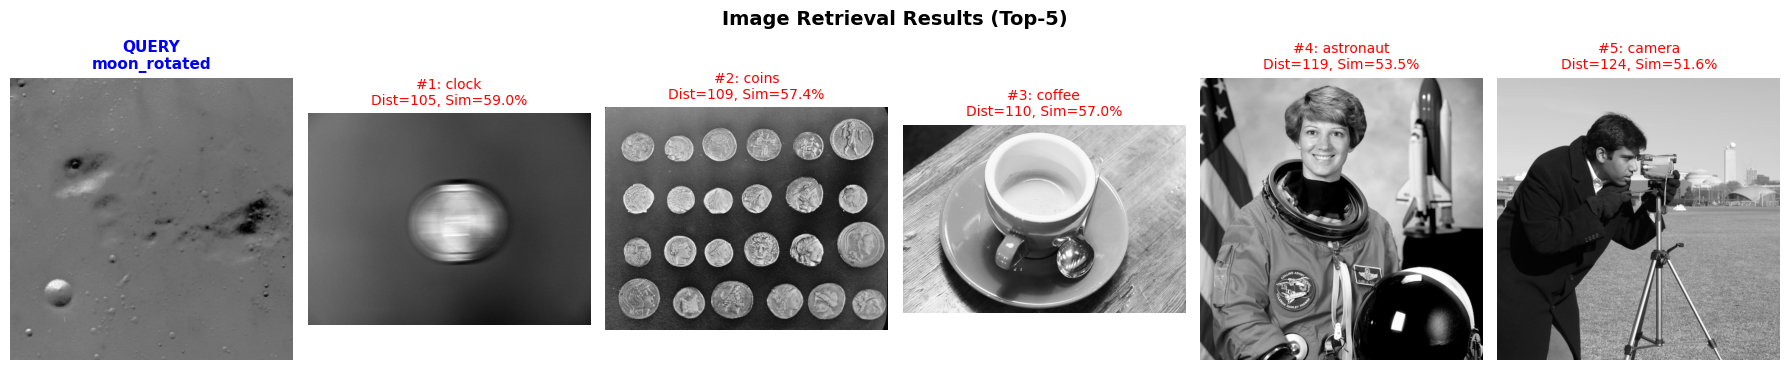


[INFO] Kết quả tìm kiếm cho 'moon_rotated':
  1. clock                | Distance: 105 | Similarity: 58.98%
  2. coins                | Distance: 109 | Similarity: 57.42%
  3. coffee               | Distance: 110 | Similarity: 57.03%
  4. astronaut            | Distance: 119 | Similarity: 53.52%
  5. camera               | Distance: 124 | Similarity: 51.56%


In [23]:
# ========================================
# DEMO 2: Tìm kiếm với Moon image
# ========================================

# Query là moon với rotation
query_moon = np.rot90(gallery_images['moon'])

image_retrieval_demo(
    query_img=query_moon,
    query_name='moon_rotated',
    gallery=gallery,
    top_k=5,
    save_path=FIGURES_DIR / "retrieval_demo_moon.png"
)

[OK] Đã lưu: D:\Workspace for Learning\My Projects\UTH Projects\UTH-CVIP-assignments\Solutions\Lab 4 (Chapter 3.1)\outputs\figures\retrieval_demo_random.png


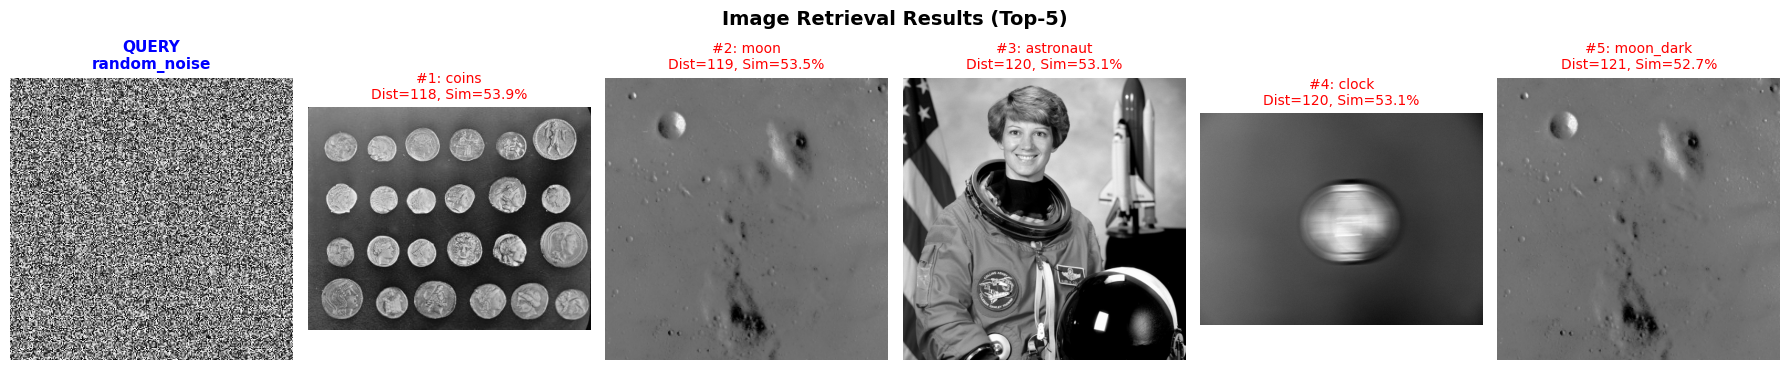


[INFO] Kết quả tìm kiếm cho 'random_noise':
  1. coins                | Distance: 118 | Similarity: 53.91%
  2. moon                 | Distance: 119 | Similarity: 53.52%
  3. astronaut            | Distance: 120 | Similarity: 53.12%
  4. clock                | Distance: 120 | Similarity: 53.12%
  5. moon_dark            | Distance: 121 | Similarity: 52.73%


In [24]:
# ========================================
# DEMO 3: Tìm kiếm với ảnh hoàn toàn mới
# ========================================

# Tạo ảnh ngẫu nhiên (noise)
query_random = np.random.randint(0, 256, size=(256, 256), dtype=np.uint8)

image_retrieval_demo(
    query_img=query_random,
    query_name='random_noise',
    gallery=gallery,
    top_k=5,
    save_path=FIGURES_DIR / "retrieval_demo_random.png"
)

In [25]:
# ========================================
# HÀM RETRIEVAL CHO NGƯỜI DÙNG (Interactive)
# ========================================

def search_similar_images(query_path_or_array, top_k=5):
    """
    Hàm tìm kiếm ảnh tương tự.
    
    Parameters
    ----------
    query_path_or_array : str or np.ndarray
        Đường dẫn ảnh hoặc numpy array.
    top_k : int
        Số lượng kết quả trả về.
        
    Returns
    -------
    list
        Danh sách (image_name, distance, similarity).
    """
    # Load ảnh nếu là path
    if isinstance(query_path_or_array, str):
        query_img = load_and_preprocess(query_path_or_array, size=CONFIG.image_size)
        query_name = Path(query_path_or_array).name
    else:
        query_img = query_path_or_array
        query_name = "custom_query"
    
    # Tìm kiếm
    image_retrieval_demo(
        query_img=query_img,
        query_name=query_name,
        gallery=gallery,
        top_k=top_k
    )

# Hướng dẫn sử dụng
print("[INFO] Hướng dẫn sử dụng hàm search_similar_images():")
print("")
print("  # Với đường dẫn ảnh:")
print("  search_similar_images('path/to/image.jpg', top_k=5)")
print("")
print("  # Với numpy array:")
print("  search_similar_images(my_image_array, top_k=3)")

[INFO] Hướng dẫn sử dụng hàm search_similar_images():

  # Với đường dẫn ảnh:
  search_similar_images('path/to/image.jpg', top_k=5)

  # Với numpy array:
  search_similar_images(my_image_array, top_k=3)


---

# Tổng kết

Trong bài thực hành này đã thực hiện:

1. **Tìm hiểu về Wavelet Transform** và cách sử dụng PyWavelets để phân rã ảnh

2. **Xây dựng thuật toán Wavelet Hash**:
   - Tiền xử lý ảnh (grayscale, resize)
   - Phân rã DWT đa cấp
   - Trích xuất features từ subband LL
   - Lượng tử hóa thành hash bits

3. **Đánh giá hiệu suất** với các metrics:
   - Accuracy, Sensitivity, Specificity
   - ROC curve và AUC

4. **So sánh các phương pháp** khác nhau:
   - Wavelet types: haar, db2, db4, sym2
   - Decomposition levels: 1, 2, 3
   - Quantization methods: median, mean

5. **Xây dựng ứng dụng Image Retrieval** để tìm kiếm ảnh tương tự

### Key Takeaways

- Wavelet hash là phương pháp hiệu quả để so sánh độ tương đồng ảnh
- LL subband (approximation) chứa thông tin chính và ổn định nhất
- Median thresholding thường robust hơn mean
- Khoảng cách Hamming nhỏ tương ứng với ảnh tương tự

In [26]:
# ========================================
# KIỂM TRA CÁC FILE OUTPUT
# ========================================

print("[INFO] Các file đã tạo:")
print("\nFigures:")
for f in FIGURES_DIR.glob("*.png"):
    print(f"  - {f.name}")

print("\nTables:")
for f in TABLES_DIR.glob("*.csv"):
    print(f"  - {f.name}")

print("\n[OK] Notebook hoàn thành!")

[INFO] Các file đã tạo:

Figures:
  - confusion_matrix.png
  - distance_distribution.png
  - methods_comparison.png
  - metrics_vs_threshold.png
  - retrieval_demo_camera.png
  - retrieval_demo_moon.png
  - retrieval_demo_random.png
  - roc_curve.png
  - sample_pairs.png
  - wavelet_decomposition.png

Tables:
  - distances.csv
  - methods_comparison.csv

[OK] Notebook hoàn thành!
